# Import Library

In [ ]:
# Import library
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math, os, sys
import itertools
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.style.use('default')

from scipy import ndimage
from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Tampilkan versi TensorFlow
print("TensorFlow Version:", tf.__version__)
print(tf.__version__)

TensorFlow Version: 2.18.0
2.18.0


# Import dataset

In [ ]:
!pip install kaggle

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dnistwn67","key":"12834b8c08f2558f43f1d35ef6ab6fc4"}'}

In [ ]:
# Pastikan direktori .kaggle ada
!mkdir -p ~/.kaggle

# Pindahkan kaggle.json ke folder yang benar
!mv kaggle.json ~/.kaggle/

# Berikan izin akses ke file
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d mrifqimajid/skin-types-dataset

# Unzip file dataset
!unzip -q skin-types-dataset.zip -d skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/mrifqimajid/skin-types-dataset
License(s): unknown
 99% 1.06G/1.07G [00:04<00:00, 243MB/s]
100% 1.07G/1.07G [00:04<00:00, 236MB/s]


In [ ]:
!ls skin-types-dataset/dataset_skin_capstone

dry  normal  oily


In [ ]:
import os
import shutil
import random
from pathlib import Path

# Path asal dataset
SOURCE_DIR = Path("skin-types-dataset/dataset_skin_capstone")

# Path tujuan
TRAIN_DIR = Path("data_split/train")
TEST_DIR = Path("data_split/test")

# Rasio data
TRAIN_RATIO = 0.8

# Membuat folder train dan test jika belum ada
for label_dir in SOURCE_DIR.iterdir():
    if label_dir.is_dir():
        label = label_dir.name
        os.makedirs(TRAIN_DIR / label, exist_ok=True)
        os.makedirs(TEST_DIR / label, exist_ok=True)

        # Ambil semua file gambar
        images = list(label_dir.glob("*"))
        random.shuffle(images)

        # Hitung jumlah data train
        train_count = int(len(images) * TRAIN_RATIO)

        # Salin gambar ke folder train dan test
        for i, img_path in enumerate(images):
            dest_dir = TRAIN_DIR / label if i < train_count else TEST_DIR / label
            shutil.copy(img_path, dest_dir / img_path.name)

print("Selesai membagi dataset menjadi train dan test.")


Selesai membagi dataset menjadi train dan test.


In [ ]:
!ls data_split

test  train


In [ ]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# import zipfile

# # Path ke file ZIP di Google Drive
# zip_path = "/content/drive/MyDrive/dataset_skin_capstone.zip"

#extract_path = "/content/skin_dataset_extracted"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ Dataset berhasil diekstrak ke:", extract_path)


In [ ]:
# Update lokasi DATA_DIR ke folder hasil ekstraksi
#DATA_DIR = extract_path
#print("DATA_DIR is now:", DATA_DIR)

# Tampilkan isi folder untuk verifikasi
#!ls "$DATA_DIR"


In [ ]:
import os
import shutil
import random

# Path setelah ekstraksi\
#SOURCE_DIR = "/content/skin_dataset_extracted/dataset_skin_capstone"
#TRAIN_DIR = "/content/datasetfinal/image/train"
#TEST_DIR = "/content/datasetfinal/image/test"

# Buat folder train dan test
for target_dir in [TRAIN_DIR, TEST_DIR]:
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

# Label/kategori kelas
labels = os.listdir(SOURCE_DIR)
print("Kelas yang ditemukan:", labels)

# Split rasio
test_ratio = 0.2  # 20% untuk test

for label in labels:
    source_folder = os.path.join(SOURCE_DIR, label)
    images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.png'))]
    random.shuffle(images)

    split_idx = int(len(images) * (1 - test_ratio))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Buat folder per label di train dan test
    os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, label), exist_ok=True)

    # Pindahkan file
    for img in train_images:
        shutil.copy(os.path.join(source_folder, img), os.path.join(TRAIN_DIR, label, img))
    for img in test_images:
        shutil.copy(os.path.join(source_folder, img), os.path.join(TEST_DIR, label, img))

print("✅ Dataset berhasil dipisah ke folder train & test.")

Kelas yang ditemukan: ['dry', 'normal', 'oily']
✅ Dataset berhasil dipisah ke folder train & test.


In [ ]:
import os

# Cek apakah direktori test ada
print("Isi folder train:")
print(os.listdir(TRAIN_DIR))
print("Isi folder test:")
print(os.listdir(TEST_DIR))

# Coba lihat isi dari salah satu label, misalnya 'oily'
oily_path = os.path.join(TEST_DIR, 'oily')
if os.path.exists(oily_path):
    print("\nIsi folder test/oily:")
    print(os.listdir(oily_path))
else:
    print("\nFolder 'oily' tidak ditemukan di dalam TEST_DIR!")



Isi folder train:
['dry', 'normal', 'oily']
Isi folder test:
['dry', 'normal', 'oily']

Isi folder test/oily:
['6ff0e7e48d6b60d086f5913e96484d26.jpg', 'bbd0552cde79b4b2c4e1e81d85f6e6f8.jpg', '6617bd4a7b861316ef2a24366b76c3fd.jpg', '19773b030be01932f8496cc3f69305d3.jpg', 'oily_new_a1d3fe16739d24747ef3_jpg.rf.e398ed1a920c940fc6d84295b50a0f6e.jpg', 'shot-of-a-young-attractive-woman-doing-her-daily-s-2025-04-06-08-36-07-utc.jpg', '0934a9e3cdb9013a0b0936bf67d40c2a.jpg', 'oily_new_4e9e84595e210c198185_jpg.rf.db2d1922a23869d225cef6dfde69af3b.jpg', 'eyes-fully-locked-on-the-prize-2025-04-05-16-36-18-utc.jpg', 'asian-woman-hands-and-beauty-portrait-for-skincar-2025-04-06-10-10-35-utc.jpg', 'a87f989dde89eedfcf436e1277b6775d.jpg', 'various_selfie-skin-with-many-pores_0e01665876e65f304ed1_jpg.rf.ac8ee9eb07833d6a736a40d3bd5649bc.jpg', '0885cbf1c94e473db2c0e5278693bb23.jpg', 'close-up-of-woman-with-eyes-closed-2025-04-05-03-13-27-utc.jpg', '6c94ec79b28f6ddf6d76eae2867a7bcf.jpg', 'oily_new_eabfc92658

In [ ]:
# import shutil

# shutil.rmtree('/content/datasetfinal/image/train/dataset_skin_capstone')
# shutil.rmtree('/content/datasetfinal/image/test/dataset_skin_capstone')


In [ ]:
# print("Isi folder train:")
# print(os.listdir(TRAIN_DIR))
# print("Isi folder test:")
# print(os.listdir(TEST_DIR))

In [ ]:
from glob import glob
import os

labels = ['dry', 'normal', 'oily']
base_path = "data_split/train"

for label in labels:
    path = os.path.join(base_path, label)
    files = glob(os.path.join(path, '*.jpg'))
    print(f"Label '{label}': {len(files)} gambar ditemukan")


Label 'dry': 478 gambar ditemukan
Label 'normal': 483 gambar ditemukan
Label 'oily': 479 gambar ditemukan


Jumlah gambar: 181


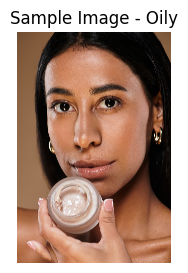

In [ ]:
sample_image_path = os.path.join(TEST_DIR, 'oily')  # Ganti 'oily' ke folder yang tersedia
sample_image_list = os.listdir(sample_image_path)
print("Jumlah gambar:", len(sample_image_list))

sample_image = imread(os.path.join(sample_image_path, sample_image_list[35]))

plt.figure(figsize=(3,3))
plt.imshow(sample_image)
plt.title("Sample Image - Oily")
plt.axis('off')
plt.show()


# Preporcessing

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Konfigurasi
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
#TRAIN_DIR = '/content/datasetfinal/image/train'  # Ganti dengan path ke folder dataset

# =========================
# 1. Data Preprocessing
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1155 images belonging to 3 classes.
Found 287 images belonging to 3 classes.


# Modelling

In [ ]:
# Define and compile the model - This section was commented out and needs to be active
from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = (224, 224, 3)

# Load pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

# Freeze base model temporarily (optional, can fine-tune later)
base_model.trainable = False

# Add Fully Connected (FC) layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(labels), activation='softmax')(x) # Ensure output layer matches number of classes (3 in this case)

# Combine into the final model
model = Model(inputs=base_model.input, outputs=output)


# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# See structure
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# =========================
# 3. Initial Training (FC Layers)
# =========================
# Now that the model is defined and compiled, this should work
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3779 - loss: 1.3612 - val_accuracy: 0.3833 - val_loss: 1.1324
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.4473 - loss: 1.1385 - val_accuracy: 0.5296 - val_loss: 1.0273
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5118 - loss: 1.0222 - val_accuracy: 0.5470 - val_loss: 0.9976
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5189 - loss: 0.9870 - val_accuracy: 0.6063 - val_loss: 0.9315
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5465 - loss: 0.9622 - val_accuracy: 0.6132 - val_loss: 0.9151
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5501 - loss: 0.9634 - val_accuracy: 0.6028 - val_loss: 0.8990
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5837 - loss: 0.9205 - val_accuracy: 0.6551 - val_loss: 0.8704
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5753 - loss: 0.9238 - val_accuracy: 0.6063 - val_loss:

In [ ]:
# =========================
# 4. Fine-Tuning Mobilenet
# =========================
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5560 - loss: 0.9303 - val_accuracy: 0.7073 - val_loss: 0.7519
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5578 - loss: 0.9166 - val_accuracy: 0.7352 - val_loss: 0.7056
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6038 - loss: 0.8579 - val_accuracy: 0.6899 - val_loss: 0.7488
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6453 - loss: 0.8161 - val_accuracy: 0.6829 - val_loss: 0.7291
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6593 - loss: 0.8112 - val_accuracy: 0.7247 - val_loss: 0.7305
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6615 - loss: 0.8007 - val_accuracy: 0.7073 - val_loss: 0.7280
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7028 - loss: 0.7254 - val_accuracy: 0.7143 - val_loss: 0.7221
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.6706 - loss: 0.7618 - val_accuracy: 0.7352 - val_loss:

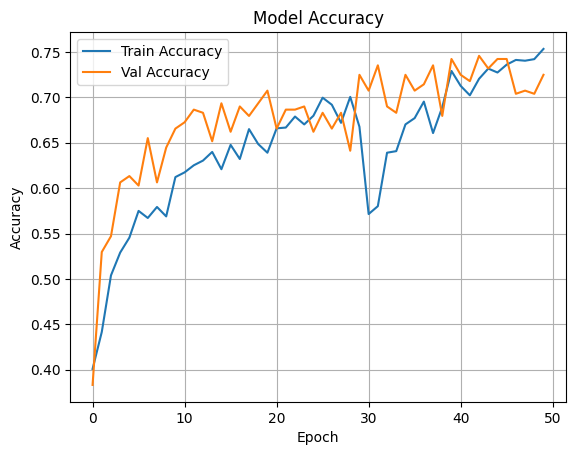

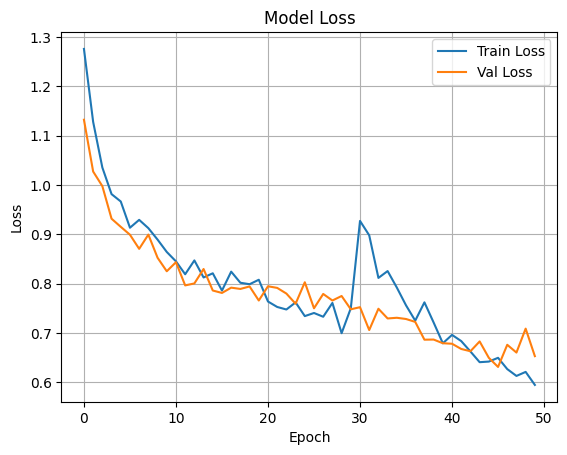

In [ ]:
# =========================
# 5. Plot History
# =========================
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'] + history_finetune.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Menyimpan Label

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=10
# )


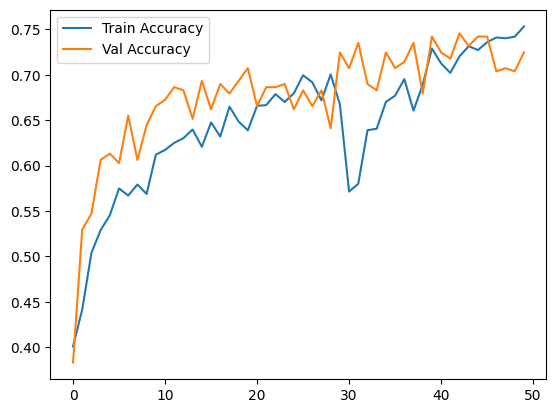

In [ ]:
# Visualisasi hasil semua pelatihan
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()


# Evaluasi

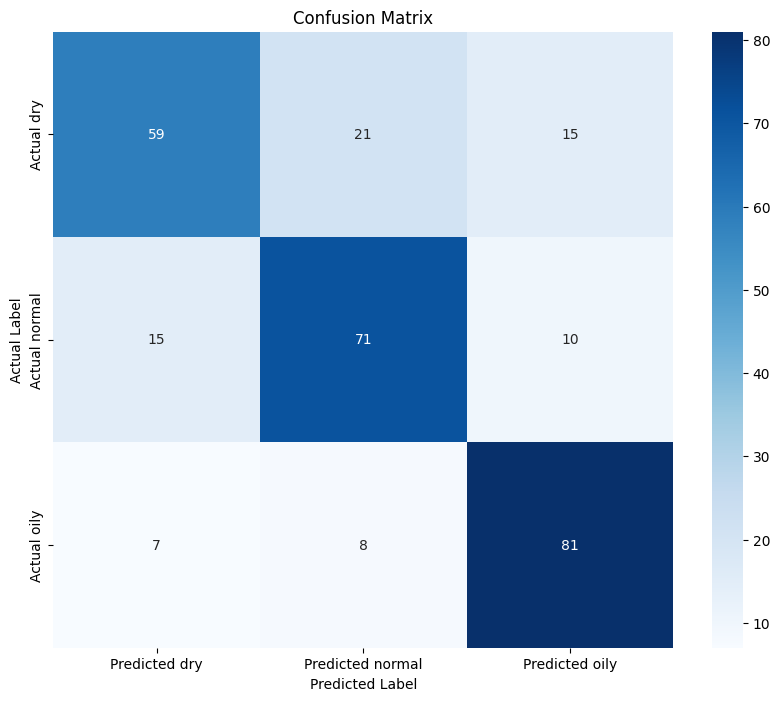


Classification Report:

              precision    recall  f1-score   support

         dry     0.7284    0.6211    0.6705        95
      normal     0.7100    0.7396    0.7245        96
        oily     0.7642    0.8438    0.8020        96

    accuracy                         0.7352       287
   macro avg     0.7342    0.7348    0.7323       287
weighted avg     0.7342    0.7352    0.7325       287



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reset generator agar urutan batch konsisten
val_generator.reset()

# Dapatkan prediksi probabilitas dari model
preds_1 = model.predict(val_generator, verbose=0)

# Ambil prediksi kelas (kelas dengan probabilitas tertinggi)
pred_classes = np.argmax(preds_1, axis=1)

# Ambil label asli
true_classes = val_generator.classes

# Ambil nama label (pastikan urutannya sama dengan class_indices)
label_map = val_generator.class_indices
label_names = [label for label, index in sorted(label_map.items(), key=lambda x: x[1])]

# Confusion Matrix
cm = pd.DataFrame(
    confusion_matrix(true_classes, pred_classes),
    index=[f"Actual {label}" for label in label_names],
    columns=[f"Predicted {label}" for label in label_names]
)

# Tampilkan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Tampilkan classification report
print("\nClassification Report:\n")
print(classification_report(
    y_true=true_classes,
    y_pred=pred_classes,
    target_names=label_names,
    digits=4
))


# Konversi Model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:

# ==================================================================================
# 1. SAVE AS TENSORFLOWJS FORMAT (.json + .bin files)
# ==================================================================================

import tensorflowjs as tfjs
import os

# Buat folder untuk TensorFlowJS
tfjs_folder = "/content/model_tfjs"
os.makedirs(tfjs_folder, exist_ok=True)

# Save model sebagai TensorFlow.js format
print("Saving TensorFlow.js format...")
try:
    tfjs.converters.save_keras_model(model, tfjs_folder)
    print(f"✅ TensorFlow.js model saved in: {tfjs_folder}")
    print("Files yang dihasilkan:")
    for file in os.listdir(tfjs_folder):
        print(f"  - {file}")
except Exception as e:
    print(f"❌ TensorFlow.js saving error: {e}")
    print("Trying alternative method...")
    # Alternative: Save as .keras first, then convert
    temp_keras_path = "/content/temp_model.keras"
    model.save(temp_keras_path)
    tfjs.converters.save_keras_model(temp_keras_path, tfjs_folder)
    os.remove(temp_keras_path)  # Clean up
    print(f"✅ TensorFlow.js model saved in: {tfjs_folder} (via Keras format)")
    print("Files yang dihasilkan:")
    for file in os.listdir(tfjs_folder):
        print(f"  - {file}")

# ==================================================================================
# 2. SAVE AS SAVEDMODEL FORMAT (.pb + variables folder)
# ==================================================================================

# Buat folder untuk SavedModel
savedmodel_folder = "/content/model_savedmodel"
os.makedirs(savedmodel_folder, exist_ok=True)

# Save model sebagai SavedModel format (Keras 3 compatible)
print("\nSaving SavedModel format...")
try:
    # Method 1: Direct SavedModel format
    tf.saved_model.save(model, savedmodel_folder)
    print(f"✅ SavedModel saved in: {savedmodel_folder}")
except Exception as e:
    print(f"Method 1 failed: {e}")
    try:
        # Method 2: Export SavedModel using tf.keras
        model.export(savedmodel_folder)
        print(f"✅ SavedModel exported in: {savedmodel_folder}")
    except Exception as e2:
        print(f"Method 2 failed: {e2}")
        # Method 3: Save as .keras format (modern alternative)
        keras_path = "/content/model.keras"
        model.save(keras_path)
        print(f"⚠️ Saved as Keras format instead: {keras_path}")
        savedmodel_folder = keras_path
print("Files yang dihasilkan:")
for root, dirs, files in os.walk(savedmodel_folder):
    level = root.replace(savedmodel_folder, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f"{subindent}{file}")

# ==================================================================================
# 3. SAVE AS TENSORFLOW LITE FORMAT (.tflite file)
# ==================================================================================

import tensorflow as tf

# Convert ke TensorFlow Lite
print("\nConverting to TensorFlow Lite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimasi untuk ukuran yang lebih kecil (opsional)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert model
tflite_model = converter.convert()

# Save TFLite model
tflite_path = "/content/model.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TensorFlow Lite model saved as: {tflite_path}")
print(f"File size: {os.path.getsize(tflite_path) / 1024:.2f} KB")

# ==================================================================================
# 4. CREATE LABELS FILE (.txt) untuk TensorFlow Lite
# ==================================================================================

# Definisikan labels kelas (sesuaikan dengan dataset Anda)
class_labels = [
    "Class_0",  # Ganti dengan nama kelas sebenarnya
    "Class_1",  # Ganti dengan nama kelas sebenarnya
    "Class_2",  # Ganti dengan nama kelas sebenarnya
    "Class_3",  # Ganti dengan nama kelas sebenarnya
    "Class_4",  # Ganti dengan nama kelas sebenarnya
    "Class_5"   # Ganti dengan nama kelas sebenarnya
]

# Atau jika Anda menggunakan ImageDataGenerator, bisa ambil dari:
# class_labels = list(train_generator.class_indices.keys())

# Save labels file
labels_path = "/content/labels.txt"
with open(labels_path, 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

print(f"✅ Labels file saved as: {labels_path}")
print("Labels:")
for i, label in enumerate(class_labels):
    print(f"  {i}: {label}")

# ==================================================================================
# 5. DOWNLOAD FILES (untuk Google Colab)
# ==================================================================================

from google.colab import files
import zipfile

print("\n" + "="*60)
print("DOWNLOADING FILES")
print("="*60)

# Zip TensorFlow.js files
print("1. Creating TensorFlow.js zip...")
tfjs_zip_path = "/content/model_tfjs.zip"
with zipfile.ZipFile(tfjs_zip_path, 'w') as zipf:
    for root, dirs, files in os.walk(tfjs_folder):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, tfjs_folder)
            zipf.write(file_path, arcname)

# Zip SavedModel files (or Keras file)
print("2. Creating SavedModel/Keras zip...")
savedmodel_zip_path = "/content/model_savedmodel.zip"
with zipfile.ZipFile(savedmodel_zip_path, 'w') as zipf:
    if os.path.isdir(savedmodel_folder):
        # If it's a directory (SavedModel format)
        for root, dirs, files in os.walk(savedmodel_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, savedmodel_folder)
                zipf.write(file_path, arcname)
    else:
        # If it's a file (Keras format)
        zipf.write(savedmodel_folder, os.path.basename(savedmodel_folder))

# Download semua file
print("3. Downloading files...")
try:
    # Download TensorFlow.js
    print("Downloading TensorFlow.js model...")
    files.download(tfjs_zip_path)

    # Download SavedModel
    print("Downloading SavedModel...")
    files.download(savedmodel_zip_path)

    # Download TensorFlow Lite
    print("Downloading TensorFlow Lite model...")
    files.download(tflite_path)

    # Download Labels
    print("Downloading labels file...")
    files.download(labels_path)

    print("✅ All files downloaded successfully!")

except Exception as e:
    print(f"❌ Download error: {e}")
    print("Anda bisa download manual dari file manager Colab")

# ==================================================================================
# 6. VERIFICATION - Test model loading
# ==================================================================================

print("\n" + "="*60)
print("VERIFICATION - Testing model loading")
print("="*60)

# Test TensorFlow.js model (butuhan tensorflowjs library)
try:
    import tensorflowjs as tfjs
    loaded_tfjs_model = tfjs.converters.load_keras_model(tfjs_folder)
    print("✅ TensorFlow.js model can be loaded successfully")
except Exception as e:
    print(f"❌ TensorFlow.js loading error: {e}")

# Test SavedModel/Keras format
try:
    if os.path.isdir(savedmodel_folder):
        # Try loading as SavedModel
        loaded_savedmodel = tf.saved_model.load(savedmodel_folder)
        print("✅ SavedModel can be loaded successfully")
    else:
        # Try loading as Keras model
        loaded_savedmodel = tf.keras.models.load_model(savedmodel_folder)
        print("✅ Keras model can be loaded successfully")
except Exception as e:
    print(f"❌ Model loading error: {e}")

# Test TensorFlow Lite model
try:
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    print("✅ TensorFlow Lite model can be loaded successfully")

    # Print input/output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print(f"  Input shape: {input_details[0]['shape']}")
    print(f"  Output shape: {output_details[0]['shape']}")

except Exception as e:
    print(f"❌ TensorFlow Lite loading error: {e}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print("Files yang telah dibuat:")
print(f"1. TensorFlow.js: {tfjs_folder}/ (model.json + .bin files)")
if os.path.isdir(savedmodel_folder):
    print(f"2. SavedModel: {savedmodel_folder}/ (saved_model.pb + variables/)")
else:
    print(f"2. Keras Model: {savedmodel_folder} (.keras file)")
print(f"3. TensorFlow Lite: {tflite_path} (.tflite file)")
print(f"4. Labels: {labels_path} (.txt file)")
print("\nSemua file siap untuk deployment! 🚀")

# ==================================================================================
# ADDITIONAL: Create proper SavedModel for production
# ==================================================================================

print("\n" + "="*60)
print("CREATING PRODUCTION-READY SAVEDMODEL")
print("="*60)

# Create a proper SavedModel for production use
proper_savedmodel_folder = "/content/production_savedmodel"
os.makedirs(proper_savedmodel_folder, exist_ok=True)

try:
    # Create a concrete function for serving
    @tf.function
    def serve_function(input_tensor):
        return model(input_tensor)

    # Get the concrete function
    concrete_function = serve_function.get_concrete_function(
        tf.TensorSpec(shape=[None, 150, 150, 1], dtype=tf.float32)
    )

    # Save with signatures
    tf.saved_model.save(
        model,
        proper_savedmodel_folder,
        signatures={'serving_default': concrete_function}
    )

    print(f"✅ Production SavedModel created: {proper_savedmodel_folder}")

    # Create zip for production SavedModel
    production_zip_path = "/content/production_savedmodel.zip"
    with zipfile.ZipFile(production_zip_path, 'w') as zipf:
        for root, dirs, files in os.walk(proper_savedmodel_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, proper_savedmodel_folder)
                zipf.write(file_path, arcname)

    print("✅ Production SavedModel zip created")

    # Test loading production SavedModel
    loaded_production_model = tf.saved_model.load(proper_savedmodel_folder)
    print("✅ Production SavedModel can be loaded successfully")

    # Add to download list
    try:
        print("Downloading production SavedModel...")
        files.download(production_zip_path)
    except:
        print("Production SavedModel available for manual download")

except Exception as e:
    print(f"❌ Production SavedModel creation failed: {e}")
    print("Using standard Keras model instead")

"""# ==================================================================================
# BONUS: Model Information
# ==================================================================================

print("\n" + "="*60)
print("MODEL INFORMATION")
print("="*60)

# Model size comparison
tfjs_size = sum(os.path.getsize(os.path.join(tfjs_folder, f))
               for f in os.listdir(tfjs_folder)) / 1024

if os.path.isdir(savedmodel_folder):
    savedmodel_size = sum(os.path.getsize(os.path.join(root, file))
                         for root, dirs, files in os.walk(savedmodel_folder)
                         for file in files) / 1024
else:
    savedmodel_size = os.path.getsize(savedmodel_folder) / 1024

tflite_size = os.path.getsize(tflite_path) / 1024

print(f"TensorFlow.js size: {tfjs_size:.2f} KB")
print(f"SavedModel/Keras size: {savedmodel_size:.2f} KB")
print(f"TensorFlow Lite size: {tflite_size:.2f} KB")
print(f"Compression ratio (TFLite vs Original): {(savedmodel_size/tflite_size):.2f}x")

# Model architecture info
print(f"\nModel Architecture:")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")"""

Saving TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file
✅ TensorFlow.js model saved in: /content/model_tfjs
Files yang dihasilkan:
  - group1-shard2of3.bin
  - group1-shard1of3.bin
  - group1-shard3of3.bin
  - model.json

Saving SavedModel format...
✅ SavedModel saved in: /content/model_savedmodel
Files yang dihasilkan:
model_savedmodel/
  saved_model.pb
  fingerprint.pb
  variables/
    variables.index
    variables.data-00000-of-00001
  assets/

Converting to TensorFlow Lite format...
Saved artifact at '/tmp/tmp409algsp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134490959916944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134490959670032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134490959916176: Tensor

'# ==================================================================================\n# BONUS: Model Information\n# ==================================================================================\n\nprint("\n" + "="*60)\nprint("MODEL INFORMATION")\nprint("="*60)\n\n# Model size comparison\ntfjs_size = sum(os.path.getsize(os.path.join(tfjs_folder, f))\n               for f in os.listdir(tfjs_folder)) / 1024\n\nif os.path.isdir(savedmodel_folder):\n    savedmodel_size = sum(os.path.getsize(os.path.join(root, file))\n                         for root, dirs, files in os.walk(savedmodel_folder)\n                         for file in files) / 1024\nelse:\n    savedmodel_size = os.path.getsize(savedmodel_folder) / 1024\n\ntflite_size = os.path.getsize(tflite_path) / 1024\n\nprint(f"TensorFlow.js size: {tfjs_size:.2f} KB")\nprint(f"SavedModel/Keras size: {savedmodel_size:.2f} KB")\nprint(f"TensorFlow Lite size: {tflite_size:.2f} KB")\nprint(f"Compression ratio (TFLite vs Original): {(savedm

In [ ]:
import zipfile
import os
from google.colab import files

# 1. Nama file zip hasilnya
zip_filename = '/content/custom_export.zip'

# 2. Buat file ZIP dan tambahkan file/folder tertentu
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Tambahkan folder tfjs_model
    tfjs_path = '/content/tfjs_model'
    for root, dirs, files_ in os.walk(tfjs_path):
        for file in files_:
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, '/content')
            zipf.write(full_path, rel_path)

    # Tambahkan file model.tflite
    tflite_file = '/content/model.tflite'
    if os.path.exists(tflite_file):
        rel_path = os.path.relpath(tflite_file, '/content')
        zipf.write(tflite_file, rel_path)

    # Tambahkan folder model_tfjs
    tfjs_folder = '/content/model_tfjs'
    if os.path.exists(tfjs_folder):
        for root, dirs, files_ in os.walk(tfjs_folder):
            for file in files_:
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, '/content')
                zipf.write(full_path, rel_path)

    # Tambahkan folder model_savedmodel
    saved_model_folder = '/content/model_savedmodel'
    if os.path.exists(saved_model_folder):
        for root, dirs, files_ in os.walk(saved_model_folder):
            for file in files_:
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(full_path, '/content')
                zipf.write(full_path, rel_path)

print(f"File ZIP berhasil dibuat: {zip_filename}")

# 3. Unduh file ZIP ke lokal
files.download(zip_filename)


=============================================================================================

## Feature Extraction

### Mengklasfikasikan jenis kulit

---



### Mempersiapkan Data Pengujian

In [ ]:
#y_test2 = to_categorical(y_test)
#X_test3, y_test3 = X_test, y_test2

# Pelatihan

### Menggunakan Model

In [ ]:
import tensorflow as tf

# Before evaluating the model, check for NaN or infinite values
tf.debugging.check_numerics(X_test3, "X_test3 contains NaN or infinite values")
tf.debugging.check_numerics(y_test3, "y_test3 contains NaN or infinite values")

# Now evaluate the model
print(model.evaluate(x=X_test3, y=y_test3))


In [ ]:
n = 32 #Jangan melampaui 31

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2, axis=1)[n]
print("Label asli adalah:", true_label,":", labels [true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:", prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:", predicted_label, ":", labels [predicted_label])

if true_label == predicted_label:
  print("Prediksi benar")
else:
  print("Prediksi salah")

if predicted_label == 0:  # Jika jenis kulit adalah acne
    recommendation = "Rekomendasi: Gunakan produk dengan kandungan salicylic acid, sulfur, mandelic acid untuk mengeringkan jerawat, dan juga mengontrol sebum di kulit wajah."
elif predicted_label == 1:  # Jika jenis kulit adalah dry
    recommendation = "Rekomendasi: Untuk kulit kering, pilihlah kandungan Hyaluronic Acid, vitamin E, essencial acid yang bermanfaat untuk membantu melembabkan kulit. ."
elif predicted_label == 2:  # Jika jenis kulit adalah normal
    recommendation = "Rekomendasi: Untuk kulit normal, kandungan Phyto-Retinol dan Hyaluronic Acid sangat bagus untuk mencegah penuaan, hidrasi, dan menjaga kulit tetap bercahaya."
elif predicted_label == 3:  # Jika jenis kulit adalah oily
    recommendation = "Rekomendasi: Gunakan skincare yang, mengandung kaolin clay,beta hydroxy acid (BHA), Asam Salisilat dan  Tea Tree Oil untuk membantu mengurangi minyak berlebih pada wajah."
else:
    recommendation = "Rekomendasi tidak tersedia untuk jenis kulit ini."

# Menampilkan rekomendasi skincare
print(recommendation)